In [17]:
import numpy as np
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import sys
sys.path.insert(1, os.getcwd()+"/../..") # Not needed if you installed SyMBac using pip
from SyMBac.colony_simulation import ColonySimulation
from SyMBac.colony_renderer import ColonyRenderer
from SyMBac.PSF import PSF_generator

#Remove directory data if it exists
if os.path.exists("data"):
    os.system("rm -rf data")

In [18]:
colonysim = ColonySimulation(
    cellmodeller_model= 'cellmodeller_ex1_simpleGrowth_modified.py',
    max_cells = 7,
    pix_mic_conv = 0.065,
    resize_amount = 3,
    save_dir = "dx_test/",
)

colonysim.run_cellmodeller_sim(num_sim=1)
colonysim.get_simulation_dirs()
pickles = colonysim.get_simulation_pickles()
colonysim.get_max_scene_size()

FRAME_CNT = len(pickles[-1])

Creating directory data/dx_test/
Set up OpenCL context:
  Platform: NVIDIA CUDA
  Device: NVIDIA GeForce RTX 3090 Ti
Importing model cellmodeller_ex1_simpleGrowth_modified
      10           2 cells           0 contacts    0.000014 hour(s) or 0.000853 minute(s) or 0.051159 second(s)
      20           2 cells           0 contacts    0.000024 hour(s) or 0.001419 minute(s) or 0.085111 second(s)
      30           2 cells           0 contacts    0.000033 hour(s) or 0.001968 minute(s) or 0.118088 second(s)
      40           2 cells           0 contacts    0.000042 hour(s) or 0.002521 minute(s) or 0.151269 second(s)
      50           2 cells           0 contacts    0.000051 hour(s) or 0.003076 minute(s) or 0.184574 second(s)
      60           4 cells           2 contacts    0.000069 hour(s) or 0.004112 minute(s) or 0.246730 second(s)
   60     4 cells       2 cts       2 iterations  residual = 0.000017
      70           4 cells           3 contacts    0.000095 hour(s) or 0.005670 minute

In [19]:
colonysim.draw_simulation_OPL(n_jobs = 1, FL=True, density = 0.1, random_distribution = "uniform", distribution_args = (0.9, 3))

Scene Draw:: 0it [00:00, ?it/s]

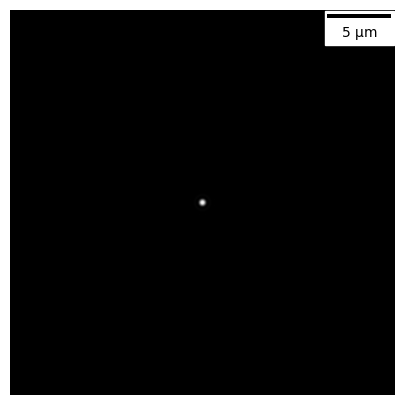

In [20]:
my_kernel = PSF_generator(
    radius = 700, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = colonysim.resize_amount, 
    pix_mic_conv = colonysim.pix_mic_conv, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0.02
)

my_kernel.calculate_PSF()
my_kernel.plot_PSF()

/home/hslab/workspace_python/symbac_daoxin/tests/dx_test_env/../../SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


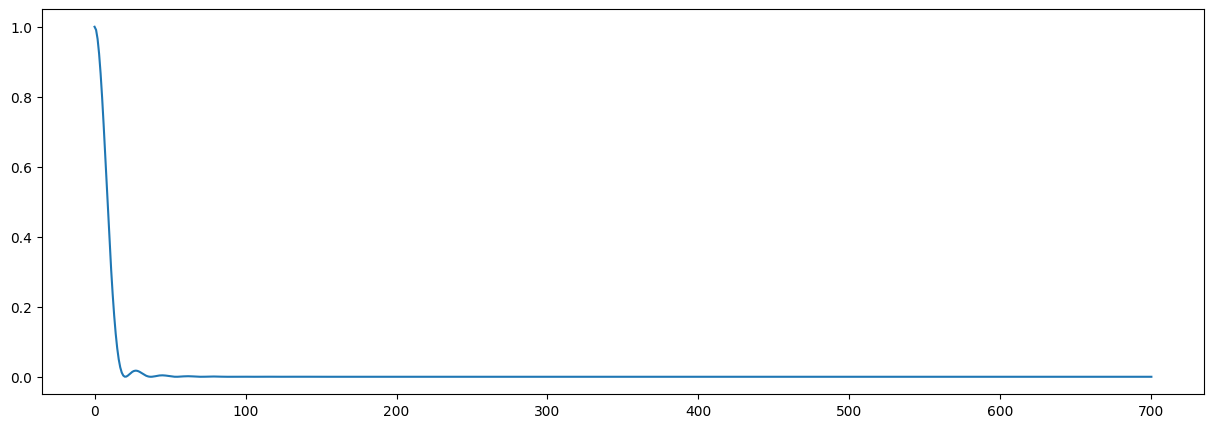

In [21]:
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
size = psf.shape[1]
central_psf = psf[psf.shape[1]//2]
central_psf = central_psf[len(central_psf)//2:]
plt.plot(central_psf)

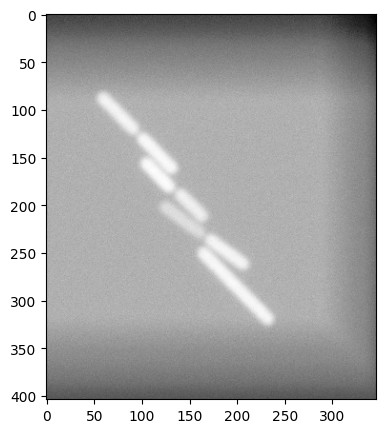

In [22]:
my_renderer = ColonyRenderer(colonysim, my_kernel)
test_img = my_renderer.render_scene(-1)
mask = my_renderer.mask_loader(-1)
plt.imshow(test_img, cmap="Greys_r")

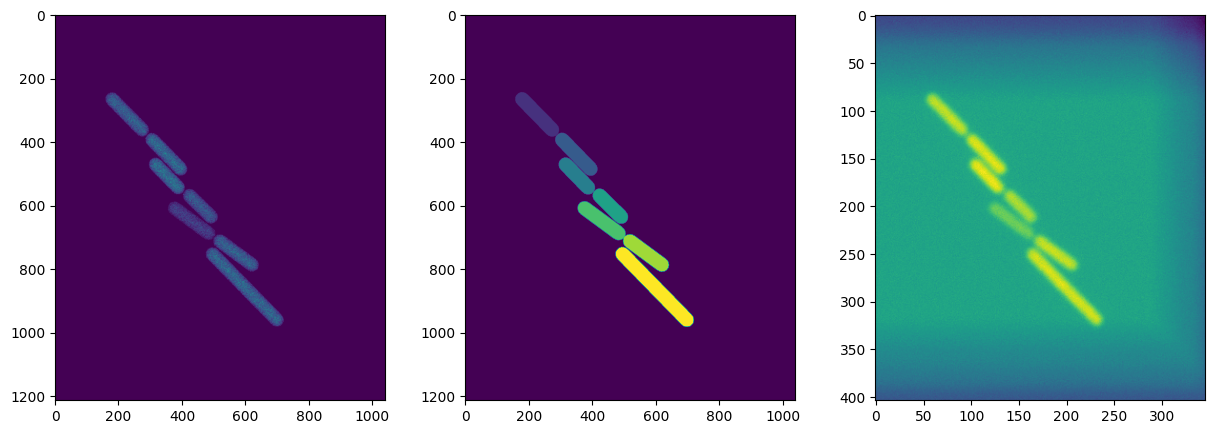

In [23]:
import os

PATH = os.getcwd()
original = mpimg.imread(PATH + '/data/scenes/00{frame}.png'.format(frame=FRAME_CNT))
mask = mpimg.imread(PATH + '/data/masks/00{frame}.png'.format(frame=FRAME_CNT))    

f, axarr = plt.subplots(1,3)
axarr[0].plot(100,100)
axarr[0].imshow(original)
axarr[1].imshow(mask)
axarr[2].imshow(test_img)
plt.show()

In [24]:
with open('ori.pkl', 'wb') as file: 
    pickle.dump(original, file)
with open('mask.pkl', 'wb') as file: 
    pickle.dump(mask, file)
with open('out.pkl', 'wb') as file: 
    pickle.dump(test_img, file)
with open('psf.pkl', 'wb') as file: 
    pickle.dump(psf, file)